In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

In [2]:
Stats=pd.read_csv('DATA_TTFL.csv')

In [3]:
Conference={'ATL':'East','BKN':'East','BOS':'East','CHA':'East','CHI':'East', 'CLE':'East', 'DAL':'West', 
            'DEN':'West' , 'DET':'East', 'GSW':'West','HOU':'West', 'IND':'East' , 'LAC':'West' , 'LAL':'West',
           'MEM':'West', 'MIA':'East', 'MIL':'East' , 'MIN':'East', 'NOP':'West', 'NYK':'East', 'OKC':'West', 'ORL':'East' ,
            'PHI':'East', 'PHX':'West', 'POR':'West', 'SAC':'West', 'SAS':'West', 'TOR':'East', 'UTA':'West', 
            'WAS':'East'}

In [4]:
Stats['TEAM']=Stats.apply(lambda x: x['MATCHUP'][:3],axis=1)
Stats['HOME']=~Stats['MATCHUP'].str.contains('@') 
Stats['CONF']=Stats.apply(lambda x: Conference.get(x['TEAM']),axis=1)
Stats['GAME_DATE']=Stats.apply(lambda x: datetime.strptime(x['GAME_DATE'],"%b %d, %Y"),axis=1)

In [5]:
Stats=Stats[['SEASON_ID', 'NAME', 'Player_ID', 'Game_ID', 'GAME_DATE','TEAM','ADV','HOME','MATCHUP',
       'WL', 'MIN', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'TOV', 'PF', 'TTFL','CONF']]

On suivra le cheminement d'un joeur débutant en TTFL c-à-d les questions qu'il se pose pour faire ses premiers picks.

La première question à se poser, la plus naturelle puisqu'on choisit un joueur pour ses performances, 
quel est le joueur le plus performant de la ligue.

Le score TTFL, qui est précisément ce qui nous interesse, nous falicite grandement la tâche, il fournit 1 critère quantifiable
pour classer les joueurs.

### Quels sont les joueurs les plus performants de la ligue ?

In [6]:
# Classement des meilleures performances de la saison 
Stats.groupby('NAME')['TTFL'].max().sort_values(ascending=False).head(30)

NAME
James Harden             97
Damian Lillard           93
Kyrie Irving             89
Joel Embiid              88
Khris Middleton          87
Anthony Davis            86
T.J. Warren              82
Giannis Antetokounmpo    80
Eric Gordon              79
Bradley Beal             78
Ben Simmons              78
Russell Westbrook        77
LeBron James             77
Nikola Jokic             76
Brandon Ingram           75
Karl-Anthony Towns       74
Trae Young               74
Andre Drummond           73
Luka Doncic              73
Devin Booker             73
Caris LeVert             72
D'Angelo Russell         72
DeMar DeRozan            71
Jayson Tatum             70
John Collins             70
Michael Porter Jr.       68
Kawhi Leonard            68
Gordon Hayward           68
Jimmy Butler             68
LaMarcus Aldridge        68
Name: TTFL, dtype: int64

In [7]:
# Classement des joueurs selon leur moyenne TTFL
Stats.groupby('NAME')['TTFL'].mean().sort_values(ascending=False).head(30)

NAME
Giannis Antetokounmpo    49.968254
James Harden             49.102941
Anthony Davis            44.677419
Luka Doncic              44.000000
Karl-Anthony Towns       43.342857
Damian Lillard           43.287879
Kawhi Leonard            41.649123
LeBron James             41.208955
Trae Young               41.083333
Russell Westbrook        40.122807
Kyrie Irving             40.100000
Bradley Beal             40.087719
Joel Embiid              40.000000
Devin Booker             38.585714
John Collins             37.682927
Nikola Jokic             37.493151
DeMar DeRozan            37.411765
Domantas Sabonis         37.129032
Andre Drummond           36.771930
Jimmy Butler             36.603448
Hassan Whiteside         35.597015
Rudy Gobert              35.573529
Jusuf Nurkic             35.375000
Ben Simmons              34.385965
Brandon Ingram           34.161290
Deandre Ayton            34.000000
Bam Adebayo              33.972222
Zion Williamson          33.916667
Nikola Vucevic 

Première observation, la moyenne la plus haute ne dépasse pas 50 pts TTFL, quand la 30e meilleure performance est à 68 pts TTFL. 
Le score TTFL semble donc être assez volatile.

In [8]:
Stats[Stats['NAME']=='Giannis Antetokounmpo']['TTFL'].std()

13.117297437486583

Giannis Antetokounmpo est le joueur à la meilleure moyenne, seulement il n'est selectionnable qu'une fois tous les 30 jours,
il convient donc de bien réfléchir à quand le jouer.

Contre quelle équipe Giannis Antetokounmpo fait il ses meilleures/ moins bonnes performances ?

In [9]:
Giannis=Stats[Stats['NAME']== 'Giannis Antetokounmpo']

In [10]:
Giannis.groupby('ADV')['TTFL'].mean().sort_values(ascending=False).head()

ADV
NOP    67.0
UTA    62.5
HOU    61.5
TOR    60.0
OKC    59.5
Name: TTFL, dtype: float64

In [11]:
Giannis.groupby('ADV')['TTFL'].mean().sort_values(ascending=True).head()

ADV
SAC    25.000000
WAS    33.000000
BKN    33.500000
CLE    37.333333
MIA    41.666667
Name: TTFL, dtype: float64

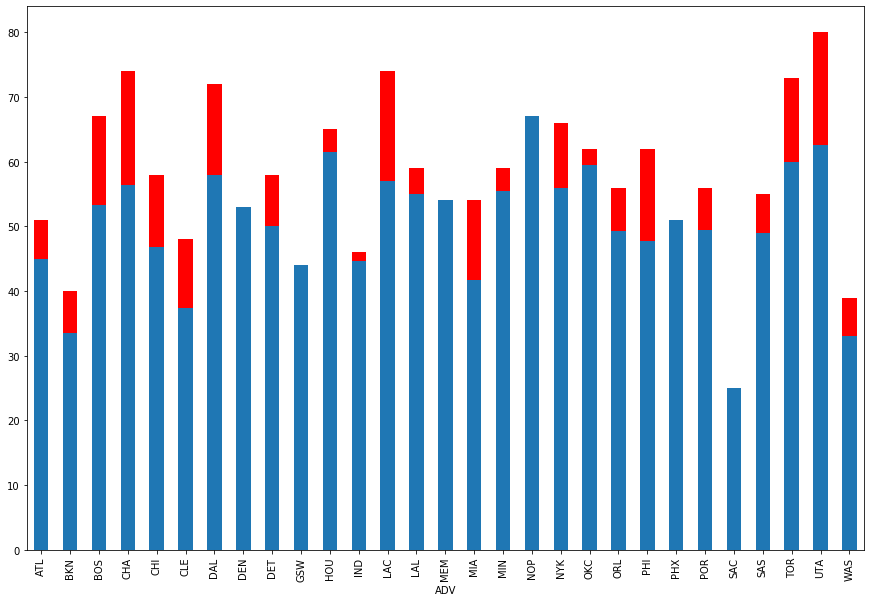

In [12]:
%matplotlib inline
Giannis.groupby('ADV')['TTFL'].max().plot(kind='bar',color='r', figsize=(15,10))
Giannis.groupby('ADV')['TTFL'].mean().plot(kind='bar',figsize=(15,10))

On peut remarquer que selon ses adversaires, le meilleur score de Giannis s'éloigne plus ou moins de sa moyenne 
contre ces mêmes adversaires

In [13]:
Giannis_mean=pd.DataFrame(Giannis.groupby('ADV')['TTFL'].mean())
Giannis_mean['ADV_East']=[Conference.get(adv)== 'East' for adv in Giannis_mean.index]

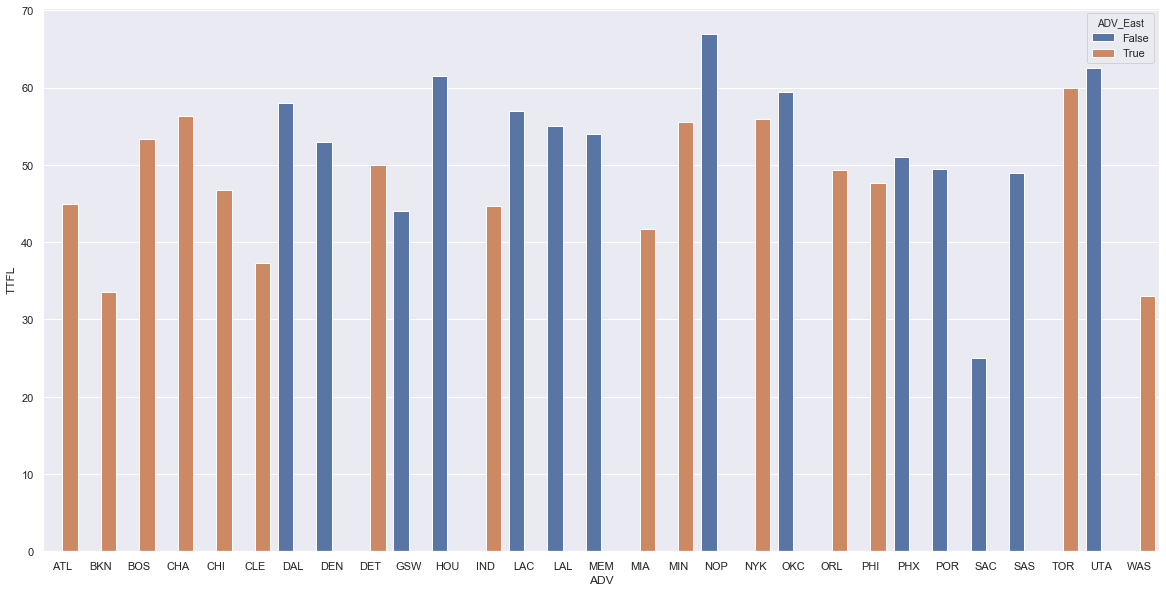

In [14]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x=Giannis_mean.index, y = Giannis_mean['TTFL'],hue=Giannis_mean['ADV_East'])

Même si l'on se restreint aux 30, 40 meilleurs joueurs, il est long et fastidieux de se livre à cette analyse pour comparer 
joueur. 
Peut être qu'en regardant directement aux niveaux des équipes, certaines sont particulièrement douées pour contenir le score de 
ses adversaires.

### Contre quelle équipe est-il le plus difficle de mettre bcp de points ?

In [15]:
Stats.groupby('ADV')['TTFL'].mean().sort_values(ascending=True).head(30)

ADV
MIL    14.928934
TOR    15.110246
LAL    15.206037
BOS    15.613546
LAC    15.675325
MIA    15.779507
OKC    15.967914
IND    16.080000
UTA    16.233244
ORL    16.309211
BKN    16.396053
PHI    16.453441
DEN    16.517287
SAC    16.557292
NYK    16.571227
MEM    16.616368
CHA    16.647826
DAL    16.660691
PHX    16.788387
DET    17.018678
GSW    17.097320
CHI    17.170623
HOU    17.364611
CLE    17.445559
SAS    17.450875
POR    17.607235
NOP    17.656000
MIN    17.985141
WAS    18.397059
ATL    18.416667
Name: TTFL, dtype: float64

L'écart de moyenne entre le min et le max nous laisse penser que cette observation n'est pas pertinente. Puisque le but du jeu est de choisir le joueur qui fera le meilleur score de la soirée, on se concentre sur le meilleur score dans chaque équipe.  

On va construire un tableau double entrée qui contiendra les meilleurs scores TTFL, pour chaque confrontation.

#### Test: construction de la ligne pour un équipe ( les Sacramento Kings)

In [15]:
Test=pd.DataFrame(Stats[Stats['TEAM']=='SAC'].groupby('ADV')['TTFL'].max())

In [16]:
Test=Test.rename(columns={'TTFL':'SAC'})

In [17]:
Test=Test.transpose()
Test['SAC']=0

In [18]:
Test

ADV,ATL,BKN,BOS,CHA,CHI,DAL,DEN,DET,GSW,HOU,...,OKC,ORL,PHI,PHX,POR,SAS,TOR,UTA,WAS,SAC
SAC,39,36,51,35,40,52,47,34,43,46,...,35,60,35,54,50,55,41,36,44,0


#### Généralisation à toutes les équipes

In [16]:
Cross=pd.DataFrame(columns=set(Stats['TEAM']))
for team in set(Stats['TEAM']):
    ligne=pd.DataFrame(Stats[Stats['TEAM']==team].groupby('ADV')['TTFL'].max())
    ligne=ligne.rename(columns={'TTFL':team})
    ligne=ligne.transpose()
    ligne[team]=0
    Cross=pd.concat([Cross,ligne])

C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


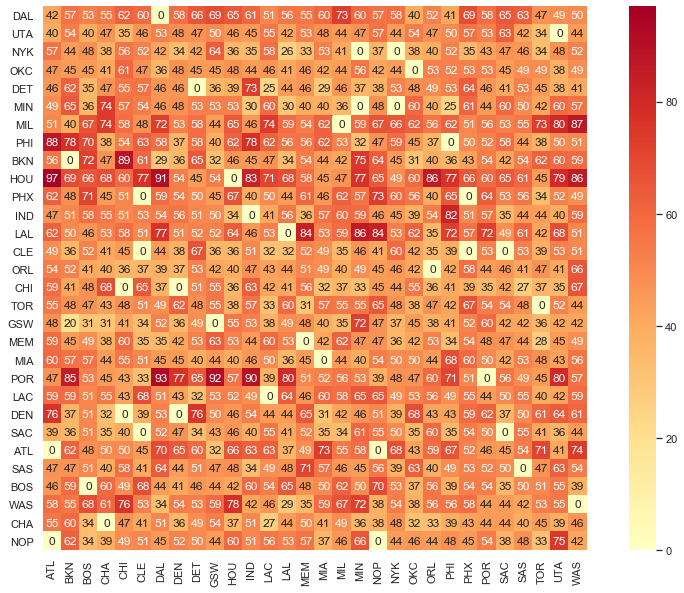

In [17]:
Crosstest=Cross.fillna(0)
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=Crosstest,annot=True,cmap='RdYlBu_r',center=True,square=True,cbar=True)

Cette Heatmap étant un peu trop dense ce qui la rend peu lisible on aimerait la réduire.
Ce qui tombe bien c'est que les équipes jouent plus de match au sein de leur conférence qu'entre conférence, 
on refait donc cette Heatmap pour les conférences East et West.

#### Séparation par conférence

In [18]:
Eastern=set(Stats[Stats['CONF']=='East']['TEAM'])
Western=set(Stats[Stats['CONF']=='West']['TEAM'])

In [19]:
Stats['Adv_East']=[Stats['ADV'][i] in Eastern for i in range(len(Stats))]
Adv_East=Stats[Stats['Adv_East']==True]
Adv_West=Stats[Stats['Adv_East']==False]

In [20]:
#Pour la conf Est
Cross_east=pd.DataFrame(columns=Eastern)
for team in Eastern:
    ligne=pd.DataFrame(Adv_East[Adv_East['TEAM']==team].groupby('ADV')['TTFL'].max())
    ligne=ligne.rename(columns={'TTFL':team})
    ligne=ligne.transpose()
    ligne[team]=0
    Cross_east=pd.concat([Cross_east,ligne])
    
#Pour la conf West
Cross_west=pd.DataFrame(columns=Western)
for team in Western:
    ligne=pd.DataFrame(Adv_West[Adv_West['TEAM']==team].groupby('ADV')['TTFL'].max())
    ligne=ligne.rename(columns={'TTFL':team})
    ligne=ligne.transpose()
    ligne[team]=0
    Cross_west=pd.concat([Cross_west,ligne])
    

C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



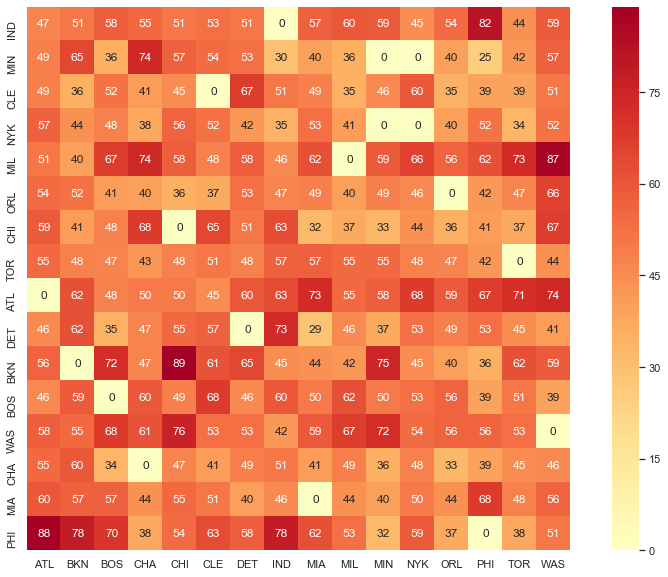

In [21]:
Cross_east=Cross_east.fillna(0)
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=Cross_east,annot=True,cmap='RdYlBu_r',center=True,square=True,cbar=True)

**Lecture:** Contre Atlanta, le meilleur score TTFL d'un joueur d'Orlando était 54

Cette heatmap, peut nous aider à choisir contre quelle équipe jouer notre meilleur joueur de Brooklyn: Boston, Chicago 
et Minesotta peuvent être de bons choix.
Mais surement pas Philadeplhie ou Orlando.

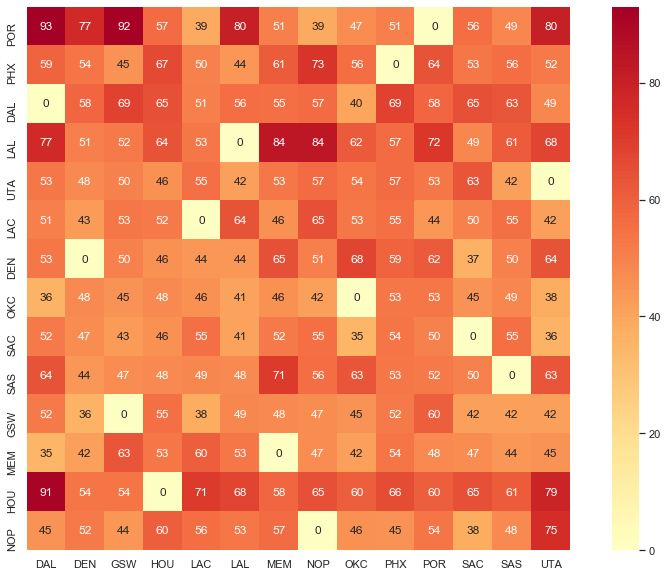

In [22]:
Cross_west=Cross_west.fillna(0)
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=Cross_west,annot=True,cmap='RdYlBu_r',center=True,square=True,cbar=True)

**Lecture:** Contre Dallas, le meilleur score TTFL d'un joueur de Portland était 93

De même on prendra un joueur de Portland contre Dalla, Golden State ou Utah, mais certainement pas contre les Clippers 
ou la Nouvelle Orléans.

### De nouvelles variables à créer 
   #### moyenne sur les n derniers matchs   

In [23]:
var_avg=['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FGA', 'FG3M',
       'FG3A' , 'FTM' , 'FTA' , 'TOV' , 'PF' , 'TTFL']

In [24]:
def avg(df):
    return(df[var_avg].shift(periods=1).rolling(2).mean().add_prefix('AVG_'))

def df_avg(df):
    df_mean=df.groupby('Player_ID').apply(avg).reset_index().set_index('level_1')
    return pd.concat([df, df_mean.drop('Player_ID', axis=1)], axis=1)

In [25]:
Stats=df_avg(Stats)

#### moyenne --------- contre l'equipe adverse

In [26]:
def avg_adv(df):
    return(df[var_avg].shift(periods=1).rolling(2).mean().add_prefix('AVG_ADV_'))

def df_avg_adv(df):
    df_mean_adv=df.groupby('Player_ID').apply(lambda x: x.groupby('ADV').apply(avg_adv)).reset_index().set_index('level_2').sort_index()
    return pd.concat([df, df_mean_adv.drop(['Player_ID','ADV'], axis=1)], axis=1)

In [ ]:
Stats=df_avg_adv(Stats)

#### série de victoire (nombre de match depuis la dernière défaite)

In [28]:
def nb_vic_df(df):
    
    # Code non vectoriel : 
    def nb_vic(df):
        # On calcul la serie de victoire jusqu'à une défaite
        serie = [0]
        for i in range(1, len(df)):
            serie += [serie[-1] + 1] if df.WL.iloc[i-1]=='W' else [0]

        return pd.Series(serie, index=df.index, name='NB_VIC').to_frame()

    # On calcul les séries pour chaque joueur
    df_nb_vic = df.groupby('Player_ID').apply(nb_vic)

    # On rajoute les séries à la fin de notre dataframe
    return pd.concat([df, df_nb_vic], axis=1)

In [29]:
Stats=nb_vic_df(Stats)

In [14]:
def nb_vic_add_df(df):
    
    # Code non vectoriel : 
    def nb_vic_add(df):

        # On calcul la serie de victoire jusqu'à une défaite
        serie = [0]
        for i in range(1, len(df)):
            serie += [serie[-1] + 1] if df.WL.iloc[i-1]=='W' else [0]
        return pd.Series(serie, index=df.index, name='NB_VIC_ADD').to_frame()

    # On calcul les séries pour chaque joueur et pour chaque équipe
    df_nb_vic_add = df.groupby('Player_ID').apply(lambda df: 
                        df.groupby('ADV').apply(nb_vic_add))  \
                                            .reset_index()  \
                                            .set_index('level_1')  \
                                            .drop('Player_ID', axis=1)

    return pd.concat([df, df_nb_vic_add], axis=1)

In [47]:
Stats=nb_vic_add_df(Stats)

In [30]:
Stats

,SEASON_ID,NAME,Player_ID,Game_ID,GAME_DATE,TEAM,ADV,HOME,MATCHUP,WL,...,AVG_FGM,AVG_FGA,AVG_FG3M,AVG_FG3A,AVG_FTM,AVG_FTA,AVG_TOV,AVG_PF,AVG_TTFL,NB_VIC
0,22019,Steven Adams,203500,21901317,2020-08-14,OKC,LAC,False,OKC @ LAC,L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,22019,Steven Adams,203500,21901306,2020-08-12,OKC,MIA,True,OKC vs. MIA,W,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,22019,Steven Adams,203500,21901265,2020-08-05,OKC,LAL,False,OKC @ LAL,W,...,2.0,4.5,0.0,0.0,0.0,1.0,0.5,0.0,8.5,1
3,22019,Steven Adams,203500,21901251,2020-08-03,OKC,DEN,True,OKC vs. DEN,L,...,5.5,8.5,0.0,0.0,2.0,4.5,0.5,1.0,23.5,2
4,22019,Steven Adams,203500,21901240,2020-08-01,OKC,UTA,True,OKC vs. UTA,W,...,5.0,8.0,0.0,0.0,3.5,5.5,1.5,4.0,25.5,0
5,22019,Steven Adams,203500,21900949,2020-03-08,OKC,BOS,False,OKC @ BOS,W,...,5.0,8.0,0.0,0.0,2.5,4.5,3.0,4.5,25.0,1
6,22019,Steven Adams,203500,21900932,2020-03-06,OKC,NYK,False,OKC @ NYK,W,...,4.0,6.0,0.0,0.0,3.0,6.5,2.5,2.0,23.0,2
7,22019,Steven Adams,203500,21900918,2020-03-04,OKC,DET,False,OKC @ DET,W,...,3.0,5.0,0.0,0.0,3.0,5.0,0.5,0.5,23.0,3
8,22019,Steven Adams,203500,21900912,2020-03-03,OKC,LAC,True,OKC vs. LAC,L,...,4.5,6.5,0.0,0.0,1.0,2.5,2.5,0.5,23.5,4
9,22019,Steven Adams,203500,21900882,2020-02-28,OKC,MIL,False,OKC @ MIL,L,...,3.0,5.5,0.0,0.0,0.0,2.5,3.0,3.0,14.0,0


## Selection de paramètres

In [31]:
Stats.sort_values(by='GAME_DATE',inplace=True)
Stats_2=Stats[['Player_ID','TEAM', 'ADV','TTFL',
       'HOME','CONF', 'AVG_PTS', 'AVG_REB', 'AVG_AST', 'AVG_STL', 'AVG_BLK',
       'AVG_FGM', 'AVG_FGA', 'AVG_FG3M', 'AVG_FG3A', 'AVG_FTM', 'AVG_FTA',
       'AVG_TOV', 'AVG_PF', 'AVG_TTFL','NB_VIC']]
Stats_2=pd.get_dummies(Stats_2)
Stats_2=Stats_2.dropna()

In [32]:
y=Stats_2.TTFL
X=Stats_2.drop('TTFL',axis=1)

In [33]:
train_X, val_X, train_y, val_y = train_test_split(X, y,shuffle=False, random_state=1)

In [211]:
TTFL_model=Lasso(alpha=0.0001,normalize=True)
TTFL_model.fit(train_X, train_y)
TTFL_model.coef_

array([-8.20481413e-07,  5.61965943e-01,  0.00000000e+00,  6.95660817e-01,
        5.56196616e-01, -5.96731267e-02,  6.85175571e-01,  1.79904215e-01,
        8.77741575e-01, -5.55577254e-01, -2.93204122e-01,  5.19962080e-01,
        3.63552468e-01,  1.08018201e+00,  2.31831880e-01,  0.00000000e+00,
       -7.01422611e-02, -8.49184365e-01, -9.53089726e-01,  3.85088164e-01,
       -8.86626472e-01, -7.78143995e-01, -7.43792160e-01,  5.82751515e-01,
       -2.93682114e-01, -3.28488770e-01, -8.30587722e-01,  2.65400658e-02,
        4.83150600e-01, -3.60291390e-01,  0.00000000e+00,  0.00000000e+00,
        1.27344983e+00,  6.22617311e-01, -1.03019980e+00,  6.19910378e-02,
       -1.33614692e+00,  9.56534978e-02, -8.32423339e-01,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -7.96772327e-01,  1.93995051e-01,
        9.65908085e-01,  1.84776246e-01,  7.16839405e-01,  1.46300443e+00,
        5.85149038e-02, -1.67958068e+00,  0.00000000e+00, -0.00000000e+00,
        8.45760804e-01, -

In [213]:
val_predictions = TTFL_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
# Mean Absolute Error et score
val_mae

8.901881554132574

In [54]:
TTFL_model.score(val_X,val_y)

0.376448837097206

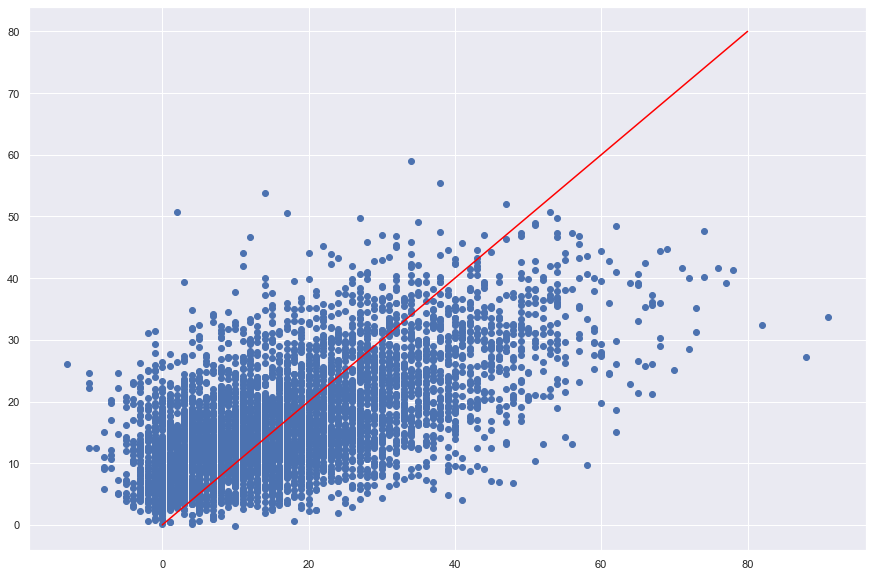

In [76]:
plt.scatter(x=val_y,y=val_predictions)
plt.plot([0, 80], [0, 80], color = 'red', linestyle = 'solid')

On essaie de se restreindre aux joueurs qui nous intéressent plus particulièrement, ceux susceptibles de faire un gros score

In [263]:
TOP=Stats.groupby('NAME')[['NAME','TTFL']].mean().sort_values(by='TTFL',ascending=False).head(50)
TOP_list=list(TOP.index)
Must=Stats[~Stats['NAME'].isin(TOP_list)]

In [264]:
Must

,SEASON_ID,NAME,Player_ID,Game_ID,GAME_DATE,TEAM,ADV,HOME,MATCHUP,WL,...,AVG_FGA,AVG_FG3M,AVG_FG3A,AVG_FTM,AVG_FTA,AVG_TOV,AVG_PF,AVG_TTFL,NB_VIC,TOP
22295,22019,Ivica Zubac,1627826,21900002,2019-10-22,LAC,LAL,True,LAC vs. LAL,W,...,4.5,0.0,0.0,6.5,7.5,1.0,2.5,26.0,1,False
19054,22019,Landry Shamet,1629013,21900002,2019-10-22,LAC,LAL,True,LAC vs. LAL,W,...,5.5,2.0,5.0,1.5,1.5,0.5,3.5,12.0,1,False
6473,22019,Derrick Favors,202324,21900001,2019-10-22,NOP,TOR,False,NOP @ TOR,L,...,7.5,0.0,0.5,0.0,0.0,3.0,2.0,17.5,0,False
3657,22019,Kentavious Caldwell-Pope,203484,21900002,2019-10-22,LAL,LAC,False,LAL @ LAC,L,...,7.0,1.0,3.0,0.5,1.0,0.5,2.0,5.5,7,False
16728,22019,Patrick Patterson,202335,21900002,2019-10-22,LAC,LAL,True,LAC vs. LAL,W,...,10.5,3.5,7.5,0.0,0.0,0.5,2.5,16.5,1,False
7343,22019,Marc Gasol,201188,21900001,2019-10-22,TOR,NOP,True,TOR vs. NOP,W,...,5.0,0.5,2.5,1.5,2.0,1.5,2.0,8.5,0,False
16197,22019,Jahlil Okafor,1626143,21900001,2019-10-22,NOP,TOR,False,NOP @ TOR,L,...,3.5,0.0,0.0,0.0,0.0,0.0,3.5,12.0,0,False
8095,22019,Danny Green,201980,21900002,2019-10-22,LAL,LAC,False,LAL @ LAC,L,...,9.0,1.5,5.0,0.5,1.0,0.5,3.0,8.0,7,False
8201,22019,JaMychal Green,203210,21900002,2019-10-22,LAC,LAL,True,LAC vs. LAL,W,...,4.5,2.5,3.0,1.5,2.0,0.5,3.5,18.0,1,False
2597,22019,Avery Bradley,202340,21900002,2019-10-22,LAL,LAC,False,LAL @ LAC,L,...,7.5,0.5,3.5,1.0,1.0,0.5,2.5,11.0,6,False


In [265]:
Must.sort_values(by='GAME_DATE',inplace=True)
Must_2=Must[['Player_ID','TEAM', 'ADV','TTFL',
       'HOME','CONF', 'AVG_PTS', 'AVG_REB', 'AVG_AST', 'AVG_STL', 'AVG_BLK',
       'AVG_FGM', 'AVG_FGA', 'AVG_FG3M', 'AVG_FG3A', 'AVG_FTM', 'AVG_FTA',
       'AVG_TOV', 'AVG_PF', 'AVG_TTFL','NB_VIC']]
Must_2=pd.get_dummies(Must_2)
Must_2=Must_2.dropna()

C:\Users\veve1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [266]:
y_must=Must_2.TTFL
X_must=Must_2.drop('TTFL',axis=1)

In [267]:
train_must_X, val_must_X, train_must_y, val_must_y = train_test_split(X_must, y_must,shuffle=False, random_state=1)

In [268]:
TTFL_model_must=Lasso(alpha=0.001,normalize=True)
TTFL_model_must.fit(train_must_X, train_must_y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [269]:
TTFL_model_must.coef_

array([-6.31678624e-07,  3.31519329e-01,  0.00000000e+00,  5.89657334e-01,
        3.62536726e-01,  0.00000000e+00,  4.40689424e-01,  0.00000000e+00,
        8.07393427e-01, -4.05067718e-01, -7.63127458e-02,  4.11909991e-01,
        1.76830764e-01,  7.73740559e-01,  3.96281334e-01,  7.85048366e-03,
       -0.00000000e+00, -8.99726384e-01, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  4.93023605e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.72464964e-01,
        0.00000000e+00, -1.51069677e-01, -0.00000000e+00,  1.47353959e-01,
        5.09388840e-03, -0.00000000e+00, -4.12265490e-01,  0.00000000e+00,
       -1.68720159e-02,  0.00000000e+00, -0.00000000e+00, -3.77530987e-01,
        0.00000000e+00, -4.71974708e-01,  0.00000000e+00,  0.00000000e+00,
        6.36500546e-01, -0.00000000e+00,  6.22606133e-01,  9.09649939e-01,
        0.00000000e+00, -6.26318989e-01,  0.00000000e+00,  0.00000000e+00,
        5.08557615e-01, -

In [270]:
val_predictions_must = TTFL_model_must.predict(val_must_X)
val_mae_must = mean_absolute_error(val_predictions_must, val_must_y)

In [271]:
val_mae_must

8.359855141872755

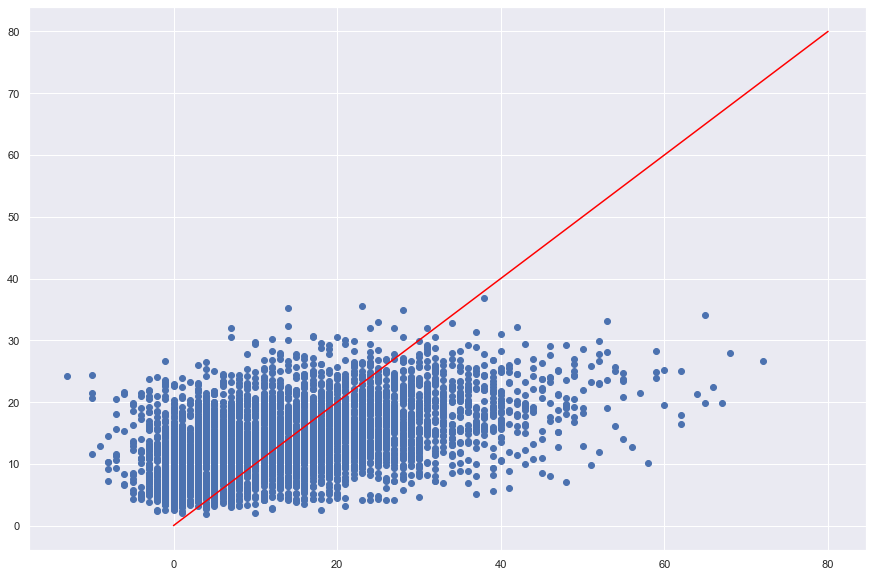

In [272]:
plt.scatter(val_must_y,val_predictions_must)
plt.plot([0, 80], [0, 80], color = 'red', linestyle = 'solid')

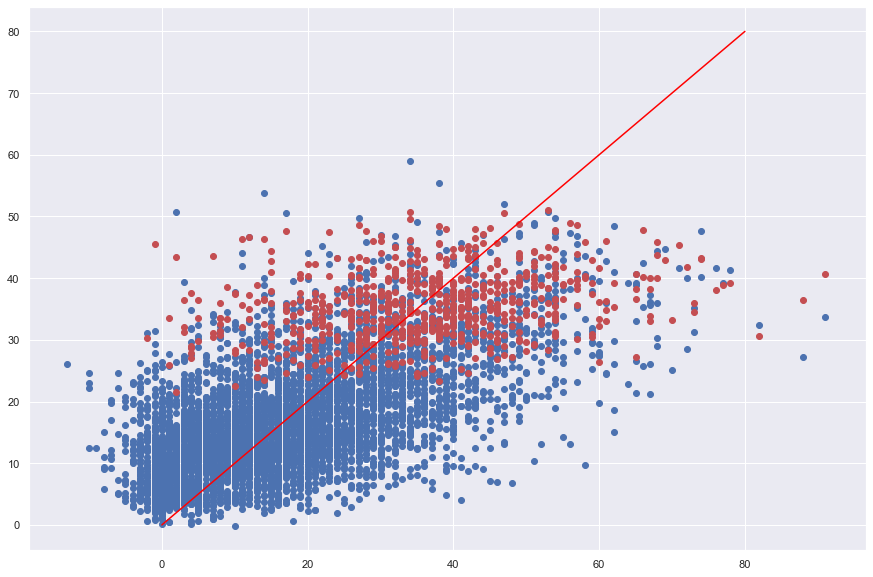

In [257]:
plt.scatter(x=val_y,y=val_predictions)
plt.scatter(val_must_y,val_predictions_must,color='r')
plt.plot([0, 80], [0, 80], color = 'red', linestyle = 'solid')

## K fold validation 

In [208]:
df=Stats.copy()
y_k=df.TTFL
X_k=df.drop('TTFL',axis=1)

In [150]:
Dates=list(set(df.GAME_DATE))
Dates.sort()

In [151]:
len(Dates)

150

In [163]:
Split_date=[Dates[0],Dates[25],Dates[50],Dates[75],Dates[100],Dates[125],Dates[149]]
Split_date

[Timestamp('2019-10-22 00:00:00'),
 Timestamp('2019-11-16 00:00:00'),
 Timestamp('2019-12-12 00:00:00'),
 Timestamp('2020-01-07 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-08-14 00:00:00')]

In [209]:
def timesplitvalidation(Model,alpha):
    global df
    mae_list=[]
    for i in range(1,6):
        #On vire les Nan
        df=df.dropna()
        #On sépare en train et test
        df_train=df[df['GAME_DATE']<Split_date[i]]
        step_df=df[df['GAME_DATE']<Split_date[i+1]]
        df_test=step_df[step_df['GAME_DATE']>Split_date[i]]
    
        y_k_train=df_train.TTFL
        X_k_train=df_train[['Player_ID','TEAM', 'ADV',
           'HOME','CONF', 'AVG_PTS', 'AVG_REB', 'AVG_AST', 'AVG_STL', 'AVG_BLK',
           'AVG_FGM', 'AVG_FGA', 'AVG_FG3M', 'AVG_FG3A', 'AVG_FTM', 'AVG_FTA',
           'AVG_TOV', 'AVG_PF', 'AVG_TTFL','NB_VIC']]
        X_k_train=pd.get_dummies(X_k_train)

        y_k_test=df_test.TTFL
        X_k_test=df_test[['Player_ID','TEAM', 'ADV',
           'HOME','CONF', 'AVG_PTS', 'AVG_REB', 'AVG_AST', 'AVG_STL', 'AVG_BLK',
           'AVG_FGM', 'AVG_FGA', 'AVG_FG3M', 'AVG_FG3A', 'AVG_FTM', 'AVG_FTA',
           'AVG_TOV', 'AVG_PF', 'AVG_TTFL','NB_VIC']]
        X_k_test=pd.get_dummies(X_k_test)
    
        TTFL_model=Model(alpha=alpha,normalize=True)
        TTFL_model.fit(X_k_train, y_k_train)
    
        predict = TTFL_model.predict(X_k_test)
        mae = mean_absolute_error(predict, y_k_test)
        mae_list+=[mae]
    return(np.mean(mae_list))

In [210]:
timesplitvalidation(Lasso,0.0001)

8.702510110549385

In [195]:
score=[]
for alpha in np.linspace(0.1,0.2,10):
    score+=[timesplitvalidation(alpha)]
score

[8.696306120153448,
 8.69630568518771,
 8.696305988350668,
 8.696306233712484,
 8.69630656244374,
 8.696306819312074,
 8.696306554934452,
 8.696306585094778,
 8.696306951298013,
 8.696307134825787]